# Portfolio Optimization - Tutorial


**December 02, 2022 <br/>**
**For NTU: Quantum Industry Day 2022 <br>**
This tutorial was adapted from [Qiskit Finance docs: Portfolio Optimization](https://qiskit.org/documentation/finance/tutorials/01_portfolio_optimization.html) and the [IBM Quantum Challenge Fall 2021](https://github.com/qiskit-community/ibm-quantum-challenge-fall-2021)

## Introduction: What is portfolio optimization?
Portfolio optimization is a crucial process for anyone who wants to maximize returns from their investments. 
Investments are usually a collection of so-called assets (stock, credits, bonds, derivatives, calls, puts, etc..) and this collection of assets is called a **portfolio**. 


</center>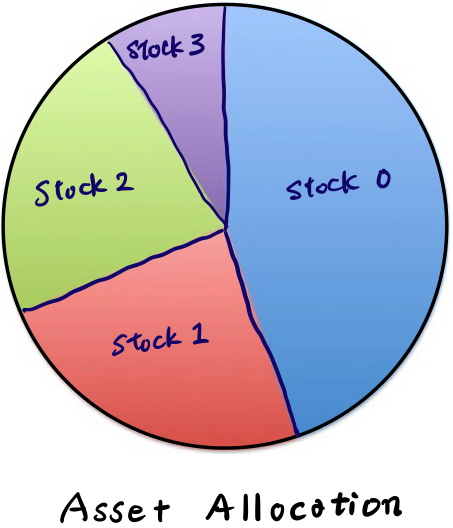 </center>


The goal of portfolio optimization is to minimize risks (financial loss) and maximize returns (financial gain). But this process is not as simple as it may seem. Gaining high returns with little risk is indeed too good to be true. Risks and returns usually have a trade-off relationship which makes optmizing your portfolio a little more complicated. As Dr. Harry Markowitz states in his Moderbn Portfolio Theory he created in 1952,  "risk is an inherrent part of higher reward."

## Introduction

This tutorial shows how to solve the following mean-variance portfolio optimization problem for $n$ assets:

$$\begin{aligned}
\min_{x \in \{0, 1\}^n}  q x^T \Sigma x - \mu^T x\\
\text{subject to: } 1^T x = B
\end{aligned}$$

where we use the following notation:

- $x \in \{0, 1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ($x[i] = 1$) and which not to pick ($x[i] = 0$),
- $\mu \in \mathbb{R}^n$ defines the expected returns for the assets,
- $\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
- $q > 0$ controls the risk appetite of the decision maker,
- and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

We assume the following simplifications:
- all assets have the same price (normalized to 1),
- the full budget $B$ has to be spent, i.e. one has to select exactly $B$ assets.

The equality constraint $1^T x = B$ is mapped to a penalty term $(1^T x - B)^2$ which is scaled by a parameter and subtracted from the objective function. 
The resulting problem can be mapped to a Hamiltonian whose ground state corresponds to  the optimal solution.
This notebook shows how to use the Variational Quantum Eigensolver (VQE) or the Quantum Approximate Optimization Algorithm (QAOA) to find the optimal solution for a given set of parameters.

Experiments on real quantum hardware for this problem are reported for instance in the following paper:
<br>
[Improving Variational Quantum Optimization using CVaR. Barkoutsos et al. 2019.](https://arxiv.org/abs/1907.04769)

## 1. Finding the efficient frontier
The Modern portfolio theory (MPT) serves as a general framework to determine an ideal portfolio for investors.  The MPT is also referred to as mean-variance portfolio theory because it assumes that any investor will choose the optimal portfolio from the set of portfolios that
- Maximizes expected return for a given level of risk; and
- Minimizes risks for a given level of expected returns.

The figure below shows the minimum variance frontier of modern portfolio theory where the horizontal axis shows the risk and the vertical axis shows expected return.  



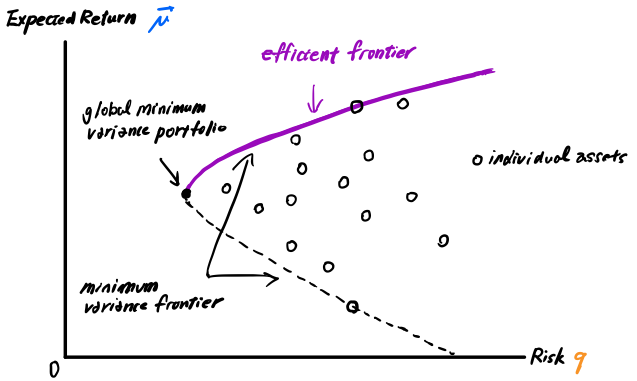



Consider a situation where you have two stocks to choose from: A and B. You can invest your entire wealth in one of these two stocks. Or you can invest 10% in A and 90% in B, or 20% in A and 80% in B, or 70% in A and 30% in B, etc ... There is a huge number of possible combinations and this is a simple case when considering two stocks. Imagine the different combinations you have to consider when you have thousands of stocks.

The minimum variance frontier shows the minimum variance that can be achieved for a given level of expected return. To construct a minimum-variance frontier of a portfolio:

- Use historical data to estimate the mean, variance of each individual stock in the portfolio, and the correlation of each pair of stocks.
- Use a computer program to find out the weights of all stocks that minimize the portfolio variance for each pre-specified expected return.
- Calculate the expected returns and variances for all the minimum variance portfolios determined in step 2 and then graph the two variables.

Investors will never want to hold a portfolio below the minimum variance point. They will always get higher returns along the positively sloped part of the minimum-variance frontier. And the positively sloped part of the minimum-variance frontier is called the **efficient frontier**.

The **efficient frontier** is where the optimal portfolios are. And it helps narrow down the different portfolios from which the investor may choose. 


In [2]:
from qiskit_aer import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime

### [Optional] Setup token to run the experiment on a real device
If you would like to run the experiment on a real device, you need to setup your account first.

Note: If you do not store your token yet, use `IBMQ.save_account('MY_API_TOKEN')` to store it first.

## Define problem instance

Here an Operator instance is created for our Hamiltonian. In this case the paulis are from an Ising Hamiltonian translated from the portfolio problem. We use a random portfolio problem for this notebook. It is straight-forward to extend this to using real financial data as illustrated here:<br>
[Loading and Processing Stock-Market Time-Series Data](11_time_series.ipynb)

In [3]:
# set number of assets (= number of qubits)
num_assets = 4
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

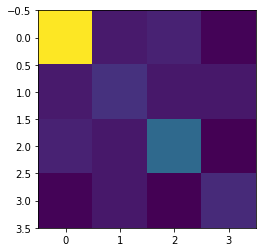

In [4]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

## Set parameters

In [5]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.001270694296030004*x_0^2 + 7.340221669347328e-05..., 4 variables, 1 constraints, 'Portfolio optimization'>

We define some utility methods to print the results in a nice format.

In [6]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

## NumPyMinimumEigensolver (as a classical reference)
Lets solve the problem. First classically...

We can now use the Operator we built above without regard to the specifics of how it was created. We set the algorithm for the NumPyMinimumEigensolver so we can have a classical reference. The problem is set for 'ising'. Backend is not required since this is computed classically not using quantum computation. The result is returned as a dictionary.

In [7]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 1.], value -0.0149

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.0149		1.0000
 [1 1 1 1]	4.0656		0.0000
 [0 1 1 1]	1.0199		0.0000
 [1 0 1 1]	1.0049		0.0000
 [0 0 1 1]	-0.0010		0.0000
 [1 1 0 1]	1.0060		0.0000
 [0 1 0 1]	0.0002		0.0000
 [0 0 0 1]	1.0191		0.0000
 [1 1 1 0]	1.0069		0.0000
 [0 1 1 0]	0.0008		0.0000
 [1 0 1 0]	-0.0140		0.0000
 [0 0 1 0]	1.0197		0.0000
 [1 1 0 0]	-0.0130		0.0000
 [0 1 0 0]	1.0208		0.0000
 [1 0 0 0]	1.0059		0.0000
 [0 0 0 0]	4.0795		0.0000


## Solution using VQE
We can now use the Variational Quantum Eigensolver (VQE) to solve the problem. We will specify the optimizer and variational form to be used.

Note: You can switch to different backends by providing the name of backend.

In [8]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 1.], value -0.0149

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.0149		0.8670
 [0 0 1 1]	-0.0010		0.1054
 [1 1 0 0]	-0.0130		0.0214
 [1 0 1 0]	-0.0140		0.0042
 [0 1 0 1]	0.0002		0.0013
 [0 1 1 0]	0.0008		0.0006
 [0 0 1 0]	1.0197		0.0001
 [1 1 1 0]	1.0069		0.0001
 [0 1 1 1]	1.0199		0.0000
 [1 0 0 0]	1.0059		0.0000
 [0 1 0 0]	1.0208		0.0000
 [0 0 0 0]	4.0795		0.0000
 [1 1 0 1]	1.0060		0.0000
 [1 0 1 1]	1.0049		0.0000
 [0 0 0 1]	1.0191		0.0000
 [1 1 1 1]	4.0656		0.0000


### Solution using QAOA

We also show here a result using the Quantum Approximate Optimization Algorithm (QAOA). This is another variational algorithm and it uses an internal variational form that is created based on the problem.

In [9]:
algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 1.], value -0.0149

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.0149		0.1684
 [1 0 1 0]	-0.0140		0.1683
 [1 1 0 0]	-0.0130		0.1680
 [0 0 1 1]	-0.0010		0.1653
 [0 1 0 1]	0.0002		0.1651
 [0 1 1 0]	0.0008		0.1649
 [0 0 0 0]	4.0795		0.0000
 [1 1 1 1]	4.0656		0.0000
 [0 1 0 0]	1.0208		0.0000
 [0 0 1 0]	1.0197		0.0000
 [1 1 1 0]	1.0069		0.0000
 [1 0 1 1]	1.0049		0.0000
 [1 1 0 1]	1.0060		0.0000
 [0 0 0 1]	1.0191		0.0000
 [1 0 0 0]	1.0059		0.0000
 [0 1 1 1]	1.0199		0.0000


In [18]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright